<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-final-project/blob/main/dtsa5511_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bank of Canada interest rate changes
DTSA5511 final project


In [1]:
!pip install scikit-learn-intelex -q
#!pip install statsmodels==0.14.0 -q
!pip install tslearn -q
!pip install scikeras -q
!pip install xgboost lightgbm catboost imbalanced-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [2]:
# file handling & general
import itertools
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')
from google.colab import files
from functools import reduce

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# ml
from sklearn.preprocessing import MinMaxScaler

## 1 Introduction

This project was first created for dtsa 5506, data mining pipeling project. It initially compared a few supervised models and some unsupervised/clustering models, with a brief attempt at a neural network. This updated version of this project is to use deep learning to predict Bank of Canada interest rate changes before they are announced. Interest rates affect nearly everyone and changes to the prevailing rates affect many decisions not just in the long term, but in the short term as well.

The bank of canada exercises counter-inflationary monetary policy by increasing interest to slow inflation, and decreasing interest to allow to avoid recession. To predict changes to the policy interest rate, it would be helpful to first model and predict inflation. The consumer price index is a common measure of inflation, and cpi time series is available from statistics canada.

The use of deep learning is a fairly new tool for central banks in the last decade. Deep learning allows hundreds or even thousands of variables to be used in prediction models.

This project is a classification? Regression? problem that involves time series, so will reuire the use of an LSTM or GRU


### 1.1 The data

In [3]:
# boc rate announcement dates, incl 2025
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/rate-announcements.csv'
#url = None
rate_announcements = pd.read_csv(url)
rate_announcements.tail(8)

,date
193,2025-01-29
194,2025-03-12
195,2025-04-16
196,2025-06-04
197,2025-07-30
198,2025-09-17
199,2025-10-29
200,2025-12-10


In [4]:
def preprocess_rate_announcements(rate_announcements):
    '''
    Preprocesses rate announcement data by:
    - Parsing dates
    - Normalizing them to the first day of the month
    - Creating a binary 'announcement' column
    - Renaming 'date' to 'Date'

    Args:
        rate_announcements (pd.DataFrame): DataFrame containing a 'date' column.

    Returns:
        pd.DataFrame: DataFrame with 'Date' column (monthly), and an 'announcement' column.
    '''

    # Ensure 'date' column exists and is datetime
    if 'date' not in rate_announcements.columns:
        raise ValueError("Input DataFrame must contain a 'date' column")

    rate_announcements['date'] = pd.to_datetime(rate_announcements['date'])

    # Normalize to the first day of the month
    rate_announcements['Date'] = rate_announcements['date'].dt.to_period('M').dt.to_timestamp()

    # Add binary flag
    rate_announcements['announcement'] = 1

    # Drop duplicates (e.g., multiple announcements in one month)
    rate_announcements = rate_announcements.drop_duplicates(subset='Date')

    # Keep only the relevant columns
    return rate_announcements[['Date', 'announcement']]

In [5]:
rate_announcements = preprocess_rate_announcements(rate_announcements)
rate_announcements.head()

,Date,announcement
0,2001-01-01,1
1,2001-03-01,1
2,2001-04-01,1
3,2001-05-01,1
4,2001-07-01,1


The data was mined from the Statistics Canada database using XLM

In [6]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}

Some data series are reported daily, other series are reported monthly, quarterly or annually. To address the various reporting periods, I need a method to fill the NA values.

In [7]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''Initialize with a dataframe of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''Extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''Transform the XML response into a structured DataFrame'''
        root = ET.fromstring(xml_content)
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # Convert date format
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''Convert quarterly date string (YYYY-Qx) to standard YYYY-MM format'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''Load df into global object with name `name` (e.g., wage, rmpi)'''
        globals()[name] = df
        self.data_objects[name] = df
        print(f'Data for {name} saved to object {name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')


My data mining project included:
* wages
* raw materials price index
* consumer price index
* rate - target

Add?:

Housing starts 34-10-0156 v52299896

Building permits 34-10-0292 v1675119645 avail > 2018-01 only

Retail trade 20-10-0067 v1446870183

Unemployment rate 14-10-0287 v2062815

Employment rate 14-10-0287 v2062817

Labour force participation rate 14-10-0287 v2062816

GDP all industries 36-10-0434 v65201210

manufacturing Industrial Production index 18-10-0267 v1230996350

manufacturing Capacity utilization rate 16-10-0015 v1707053279

1 trading partner US exchange rate 33-10-0036 v111666248 avail > 2017-01

2 trading partner Chinese renminbi exchange rate 33-10-0036 v111666226 avail > 2017-01

3 trading partner Euro 33-10-0036 v111666227 avail > 2017-01

4 trading partner Japanese yen 33-10-0036 v111666231 avail > 2017-01

S&P TSX composite close 10-10-0125 v122620

# nts: to get the table with vector ids, need to select 'download selected data (for database loading)'

In [18]:
# metadata - info to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi',
             'house_st', # removed building permits & retail
             'unemp', 'empl', 'lab_part',
             'gdp', 'mf_ipi', # removed mf_cap
             'us_fx', 'cn_fx', 'eu_fx',
             'jp_fx', 'tsx_cl', 'rate'],
    'tableid': [14100223, 18100268, 18100004,
                34100156,  # removed building permits & retail
                14100287, 14100287, 14100287,
                36100434, 18100267, # removed mf_cap
                33100036, 33100036, 33100036,
                33100036, 10100125, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seas adj, 2002 = 100',
                  'housing starts',
                  'unemployment rate',
                  'employment rate',
                  'labour force participation rate',
                  'gross domestic product',
                  'manufacturing indust prod idx',
                  'usd exchange rate',
                  'china renminbi exchange rate',
                  'euro exchange rate',
                  'japan yen exchange',
                  's&p tsx close',
                  'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973',
               'v52299896', # removed bldg & retail
               'v2062815', 'v2062817', 'v2062816',
               'v65201210', 'v1230996350', # removed mf_cap
               'v111666275', 'v111666253', 'v111666254',
               'v111666258', 'v122620', 'v39078'],
    'frequency': ['monthly', 'monthly', 'monthly',
                  'monthly', # removed bldg & retail
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', # removed mf_cap
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly, 'daily'],
    'start': ['2001-01', '2001-01', '2001-01',
              '2001-01', # removed bldg & retail
              '2001-01','2001-01', '2001-01',
              '2001-01','2001-01', # removed mf_cap
              '2017-01-01', '2017-01-01', '2017-01-01',
              '2017-01-01', '2001-01-01', '2001-01-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12',
            '2024-12', # removed bldg & retail
            '2024-12', '2024-12', '2024-12',
            '2024-12', '2024-12', # removed mf_cap
            '2024-12-31', '2024-12-31', '2024-12-31',
            '2024-12-31', '2024-12', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [19]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage
Processing rmpi...
Data for rmpi saved to object rmpi
Processing cpi...
Data for cpi saved to object cpi
Processing house_st...
Data for house_st saved to object house_st
Processing unemp...
Data for unemp saved to object unemp
Processing empl...
Data for empl saved to object empl
Processing lab_part...
Data for lab_part saved to object lab_part
Processing gdp...
Data for gdp saved to object gdp
Processing mf_ipi...
Data for mf_ipi saved to object mf_ipi
Processing mf_cap...
Data for mf_cap saved to object mf_cap
Processing us_fx...
Data for us_fx saved to object us_fx
Processing cn_fx...
Data for cn_fx saved to object cn_fx
Processing eu_fx...
Data for eu_fx saved to object eu_fx
Processing jp_fx...
Data for jp_fx saved to object jp_fx
Processing tsx_cl...
Data for tsx_cl saved to object tsx_cl
Processing rate...
Data for rate saved to object rate


In [11]:
# check to see if data loaded correctly
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3), '\n')

wage
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14 

rmpi
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5 

cpi
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1 

house_st
      Date    Value
0  2001-01  141.470
1  2001-02  126.744
2  2001-03  131.271 

bldg
      Date      Value
0  2018-01  8332584.0
1  2018-02  8352147.0
2  2018-03  8420193.0 

retail
      Date    Value
0  2017-01  50138.0
1  2017-02  49903.0
2  2017-03  50350.0 

unemp
      Date  Value
0  2001-01    6.9
1  2001-02    7.0
2  2001-03    7.1 

empl
      Date  Value
0  2001-01   61.4
1  2001-02   61.3
2  2001-03   61.2 

lab_part
      Date  Value
0  2001-01   65.9
1  2001-02   65.9
2  2001-03   66.0 

gdp
      Date      Value
0  2001-01  1434295.0
1  2001-02  1433843.0
2  2001-03  1434685.0 

mf_ipi
      Date  Value
0  2001-01   77.1
1  2001-02   77.5
2  2001-03   77.8 

mf_cap
      Date  Value
0  2017-01   79.6
1  2017-02   79.2
2  2017

In [20]:
# Your variable lists
variables = ['wage', 'rmpi', 'cpi', 'house_st', # removed bldg & retail
             'unemp', 'empl', 'lab_part', 'gdp', 'mf_ipi', 'mf_cap',
             'us_fx', 'cn_fx', 'eu_fx', 'jp_fx', 'tsx_cl', 'rate']

daily = ['tsx_cl']  # Excludes 'rate' since we process it separately

def rename_value_column(vars_list):
    """Rename 'Value' column to the variable name."""
    for var in vars_list:
        df = globals()[var]
        df.rename(columns={'Value': var}, inplace=True)

def convert_daily_to_monthly(daily_vars):
    """Convert daily dataframes to monthly averages."""
    for var in daily_vars:
        df = globals()[var].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
        df_monthly = df.groupby('Month', as_index=False)[var].mean()
        df_monthly.rename(columns={'Month': 'Date'}, inplace=True)
        globals()[var] = df_monthly

def preprocess_rate(rate_df):
    """
    Cleans and transforms daily interest rate DataFrame to monthly,
    applying the new rate to the first day of the month of change.
    """
    rate_df['Date'] = pd.to_datetime(rate_df['Date'])
    rate_df['rate'] = pd.to_numeric(rate_df['rate'], errors='coerce')

    rate_df = rate_df.sort_values('Date')
    rate_df['prev_rate'] = rate_df['rate'].shift(1)
    rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']
    rate_changes = rate_df[rate_df['rate_changed']].copy()
    rate_changes['Date'] = rate_changes['Date'].dt.to_period('M').dt.to_timestamp()
    rate_changes = rate_changes.groupby('Date')['rate'].last().reset_index()
    monthly_rate_df = rate_changes.set_index('Date').resample('MS').ffill().reset_index()
    return monthly_rate_df

def ensure_date_datetime(vars_list):
    """Ensure all 'Date' columns are datetime dtype."""
    for var in vars_list:
        df = globals()[var]
        df['Date'] = pd.to_datetime(df['Date'])

def merge_on_date(vars_list):
    """Merge all dataframes on 'Date' column using outer join."""
    dfs = [globals()[var] for var in vars_list]
    merged = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)
    return merged

# --- RUN CLEANING PIPELINE ---

# Step 1: Rename 'Value' columns
rename_value_column(variables)

# Step 2: Convert daily FX and equity series to monthly averages
convert_daily_to_monthly(daily)

# Step 3: Preprocess rate series using custom logic
rate = preprocess_rate(rate)  # This replaces the global 'rate'

# Step 4: Ensure all Date columns are datetime
ensure_date_datetime(variables)

# Step 5: Merge all data on Date
data = merge_on_date(variables)

The interest rate data is published (almost) daily, but only changes at 8 pre-determined dates per year. This will require some extra wrangling to align with the other monthly series. Where there is a rate change, I'll apply changed rate to that entire month, effective on the 1st day, so that rate_df can be aligned with the rate announcement data.

In [21]:
# Ensure 'Date' columns are datetime
data['Date'] = pd.to_datetime(data['Date'])
rate_announcements['Date'] = pd.to_datetime(rate_announcements['Date'])

# Merge on 'Date'
merged_data = pd.merge(data, rate_announcements, on='Date', how='left')

# Fill missing values in 'announcement' column with 0
merged_data['announcement'] = merged_data['announcement'].fillna(0).astype(int)

# Optional: set 'Date' as index
merged_data = merged_data.set_index('Date')

# Preview
print(merged_data.head())

              wage  rmpi   cpi  house_st  unemp  empl  lab_part        gdp  \
Date                                                                         
2001-01-01  657.14  65.2  96.3   141.470    6.9  61.4      65.9  1434295.0   
2001-02-01  653.59  65.8  96.8   126.744    7.0  61.3      65.9  1433843.0   
2001-03-01  655.14  65.5  97.1   131.271    7.1  61.2      66.0  1434685.0   
2001-04-01  652.44  65.2  97.8   144.474    7.1  61.3      66.0  1433399.0   
2001-05-01  652.28  65.3  98.6   139.901    7.0  61.3      66.0  1439506.0   

            mf_ipi  mf_cap  us_fx  cn_fx  eu_fx  jp_fx   tsx_cl  rate  \
Date                                                                    
2001-01-01    77.1     NaN    NaN    NaN    NaN    NaN  9321.87  5.75   
2001-02-01    77.5     NaN    NaN    NaN    NaN    NaN  8078.72  5.75   
2001-03-01    77.8     NaN    NaN    NaN    NaN    NaN  7608.00  5.25   
2001-04-01    78.2     NaN    NaN    NaN    NaN    NaN  7946.63  5.00   
2001-05-01    7

In [28]:
merged_data.head()

,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
Date,,,,,,,,,,,,,,,,
2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,77.1,NaN,NaN,NaN,NaN,9321.87,5.75,1
2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,77.5,NaN,NaN,NaN,NaN,8078.72,5.75,0
2001-03-01,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,77.8,NaN,NaN,NaN,NaN,7608.00,5.25,1
2001-04-01,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,78.2,NaN,NaN,NaN,NaN,7946.63,5.00,1
2001-05-01,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,78.5,NaN,NaN,NaN,NaN,8161.87,4.75,1


In [29]:
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2001-01-01 to 2024-12-01
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wage          288 non-null    float64
 1   rmpi          288 non-null    float64
 2   cpi           288 non-null    float64
 3   house_st      288 non-null    float64
 4   unemp         288 non-null    float64
 5   empl          288 non-null    float64
 6   lab_part      288 non-null    float64
 7   gdp           288 non-null    float64
 8   mf_ipi        288 non-null    float64
 9   us_fx         96 non-null     float64
 10  cn_fx         96 non-null     float64
 11  eu_fx         96 non-null     float64
 12  jp_fx         96 non-null     float64
 13  tsx_cl        273 non-null    float64
 14  rate          288 non-null    float64
 15  announcement  288 non-null    int64  
dtypes: float64(15), int64(1)
memory usage: 38.2 KB
None


* we have 288 months of data
* retail, mf_cap, unavailable from stats can before 2017 - dropped
* building permits series unavailable from stats can before 2018 - dropped
* tsx_cl only avail from stats can until sept 2023 - need to append .csv from yahoo finance.
* fx rates only available from 2017 onwards from stats can. get this info from boc

In [71]:
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/fx-2001-2016%20-%20fx-2001-2017.csv'
hist_fx = pd.read_csv(url)
hist_fx['Date'] = pd.to_datetime(hist_fx['date'])
hist_fx = hist_fx.drop(columns=['date'])
hist_fx.tail()

,cn_fx,eu_fx,jp_fx,us_fx,Date
187,0.1954,1.4563,0.01284,1.299323,2016-08-01
188,0.1965,1.4704,0.01288,1.310233,2016-09-01
189,0.1968,1.4594,0.01275,1.325305,2016-10-01
190,0.1963,1.4486,0.01238,1.343990,2016-11-01
191,0.1926,1.4060,0.01150,1.333565,2016-12-01


In [73]:
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/tsx_cl-2023-2024.csv'

hist_tsx = pd.read_csv(url)
hist_tsx['tsx_cl'] = hist_tsx['tsx_cl'].str.replace(',', '').astype(float)
hist_tsx['Date'] = pd.to_datetime(hist_tsx['Date'])
hist_tsx['Month'] = hist_tsx['Date'].dt.to_period('M').dt.to_timestamp()

# Group by 'Month' and compute the average (assuming closing value is in 'tsx_cl' column)
tsx_monthly = hist_tsx.groupby('Month', as_index=False)['tsx_cl'].mean()

# Optional: rename 'Month' to 'Date' for consistency
tsx_monthly.rename(columns={'Month': 'Date'}, inplace=True)

# Preview result
print(tsx_monthly.head())
tsx_monthly.head()

        Date        tsx_cl
0 2023-10-01  19204.652381
1 2023-11-01  19897.900000
2 2023-12-01  20590.873684
3 2024-01-01  20976.054545
4 2024-02-01  21116.205000


,Date,tsx_cl
0,2023-10-01,19204.652381
1,2023-11-01,19897.900000
2,2023-12-01,20590.873684
3,2024-01-01,20976.054545
4,2024-02-01,21116.205000


In [30]:
# Merge hist_fx into data on 'Date' using outer join
data = pd.merge(merged_data, hist_fx, on='Date', how='outer', suffixes=('', '_hist'))

# For each fx column, fill missing values using the historical version
fx_vars = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']

for var in fx_vars:
    hist_col = f"{var}_hist"
    if hist_col in data.columns:
        data[var] = data[var].fillna(data[hist_col])
        data.drop(columns=hist_col, inplace=True)

data.head()

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,77.1,1.502864,0.1816,1.4099,0.012875,9321.87,5.75,1
1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,77.5,1.523125,0.1839,1.4008,0.013096,8078.72,5.75,0
2,2001-03-01,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,77.8,1.558441,0.1883,1.4154,0.012829,7608.00,5.25,1
3,2001-04-01,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,78.2,1.558495,0.1882,1.3906,0.012588,7946.63,5.00,1
4,2001-05-01,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,78.5,1.541123,0.1862,1.3482,0.012670,8161.87,4.75,1


In [77]:
print(tsx_monthly.columns)
print(tsx_monthly.head())


Index(['Date', 'tsx_cl'], dtype='object')
        Date        tsx_cl
0 2023-10-01  19204.652381
1 2023-11-01  19897.900000
2 2023-12-01  20590.873684
3 2024-01-01  20976.054545
4 2024-02-01  21116.205000


In [76]:
# Merge on 'Date'
data = pd.merge(data, tsx_monthly, on='Date', how='left')

# Preview the merged data
print(data[['Date', 'tsx_cl']].tail())

KeyError: "['tsx_cl'] not in index"

In [31]:
# descriptive stats
data.describe()

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
count,288,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,288.000000,288.000000,288.000000,288.000000,288.000000,273.000000,288.000000,288.000000
mean,2012-12-15 17:00:00,911.699514,99.124653,123.738542,191.275632,6.979167,61.790625,66.427778,1.836635e+06,94.009722,1.239341,0.175529,1.465478,0.011273,13237.792674,2.242188,0.666667
min,2001-01-01 00:00:00,652.280000,55.300000,96.300000,95.831000,4.800000,51.900000,60.100000,1.433233e+06,74.800000,0.955770,0.130000,1.230700,0.008420,6180.420000,0.500000,0.000000
25%,2006-12-24 06:00:00,772.157500,84.075000,109.775000,173.356250,6.200000,61.400000,65.800000,1.656228e+06,82.275000,1.091370,0.155500,1.406375,0.010247,10868.210000,1.000000,0.000000
50%,2012-12-16 12:00:00,903.520000,97.050000,122.200000,189.005500,7.000000,61.800000,66.300000,1.806828e+06,92.000000,1.264557,0.184550,1.464800,0.011580,13361.260000,1.750000,1.000000
75%,2018-12-08 18:00:00,1009.772500,112.725000,134.225000,209.608000,7.500000,62.400000,67.200000,2.042136e+06,99.625000,1.342275,0.192825,1.533150,0.012225,15442.680000,3.250000,1.000000
max,2024-12-01 00:00:00,1291.170000,166.600000,162.100000,290.954000,14.200000,63.600000,67.700000,2.285235e+06,132.700000,1.599618,0.216300,1.680700,0.013600,21890.160000,5.750000,1.000000
std,NaN,170.201881,24.301023,17.143681,31.992781,1.169822,1.211767,0.915636,2.395457e+05,15.301474,0.164430,0.020802,0.090064,0.001255,3776.432942,1.522531,0.472225


for plotting, data will need to be scaled

In [32]:
numeric_cols = data.columns.drop('Date')

# Apply MinMax scaling
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(data[numeric_cols])

# Create scaled DataFrame with same column names and original 'Date'
data_minmax_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)
data_minmax_scaled.insert(0, 'Date', data['Date'])  # Add Date column back


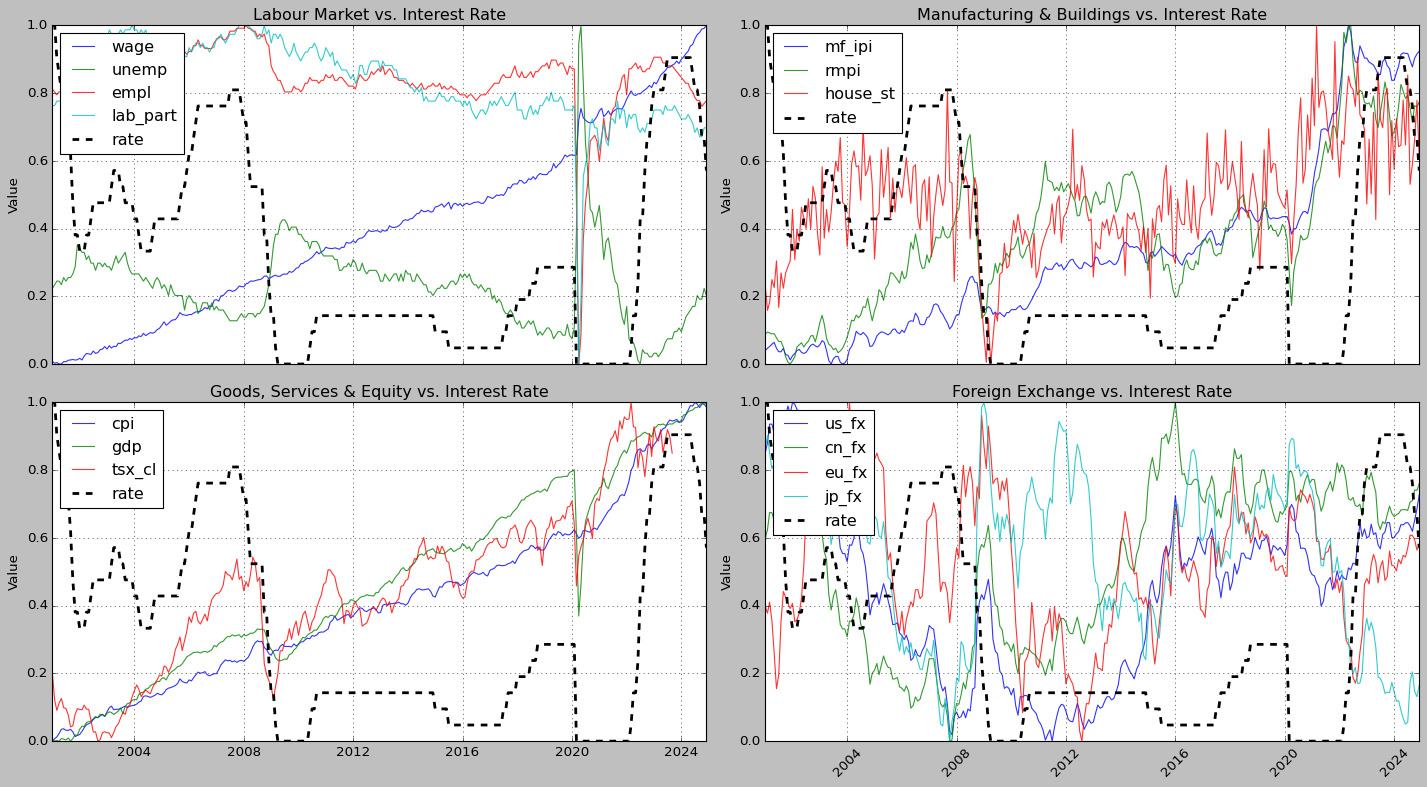

In [38]:
# Set plotting style
plt.style.use('classic')

# Groups of variables
labour_vars = ['wage', 'unemp', 'empl', 'lab_part']
mf_vars     = ['mf_ipi', 'rmpi', 'house_st']
gs_vars     = ['cpi', 'gdp', 'tsx_cl']
fx_vars     = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']
groups = {
    'Labour Market': labour_vars,
    'Manufacturing & Buildings': mf_vars,
    'Goods, Services & Equity': gs_vars,
    'Foreign Exchange': fx_vars
}

# Plot each group with 'rate'
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, (title, vars_) in enumerate(groups.items()):
    ax = axes[i]

    # Plot each variable in the group
    for var in vars_:
        ax.plot(data_minmax_scaled['Date'], data_minmax_scaled[var], label=var, alpha=0.8)

    # Plot 'rate' on the same axis (or use a twin axis if needed)
    ax.plot(data_minmax_scaled['Date'], data_minmax_scaled['rate'], label='rate', color='black', linewidth=2.5, linestyle='--')

    ax.set_title(f'{title} vs. Interest Rate')
    ax.set_ylabel('Value')
    ax.legend(loc='upper left')
    ax.grid(True)

# Format x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
exclude_cols = ['Date', 'rate', 'announcement']
feature_cols = [col for col in data.columns if col not in exclude_cols]

correlation_matrix = data[feature_cols + ['rate']].corr()
rate_correlation = correlation_matrix['rate'].drop(labels=['rate']).sort_values(ascending=False)

print(rate_correlation)


empl        0.426305
us_fx       0.255054
lab_part    0.200855
house_st    0.161438
eu_fx       0.055311
rmpi        0.050729
mf_ipi      0.048921
cpi        -0.044501
gdp        -0.103649
wage       -0.118164
tsx_cl     -0.220215
cn_fx      -0.256279
unemp      -0.458009
jp_fx      -0.503754
Name: rate, dtype: float64


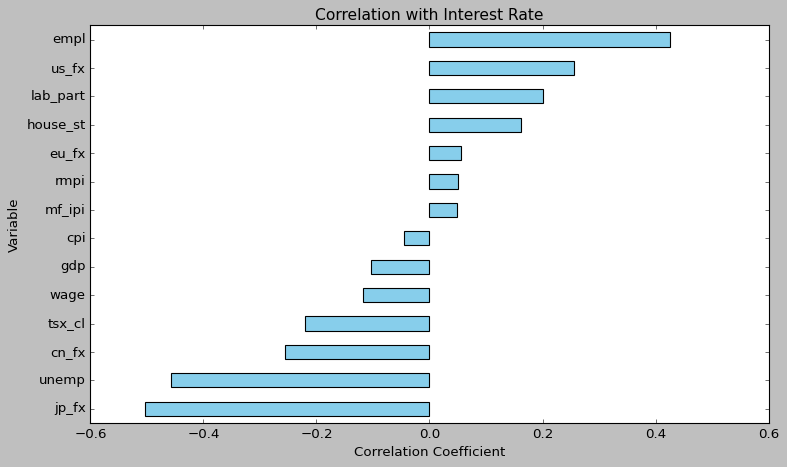

In [40]:
# Set style
plt.style.use('classic')

# Plot
plt.figure(figsize=(10, 6))
rate_correlation.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Correlation with Interest Rate', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variable')
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.tight_layout()
plt.show()

While some variables show very little correlation with the corresponding interest rate, more patterns will show up when lagged variables are included. The interest rate decisions the central bank makes are rarely based on the current month's data, but on the data from the previous months. It also takes time for effects from changes in something like the raw materials price index and foreign exchange rates to trickle down through the manufacturing sector and into retail sales and the consumer price index.

### Feature engineering

In [41]:
ml_df = data.copy()
ml_df = ml_df.reset_index()

In [42]:
# categorical target - rate_change
ml_df['rate_diff'] = ml_df['rate'].diff().fillna(0)
ml_df['rate_change'] = ml_df['rate_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

ml_df['rate_change'].unique()

array([ 0, -1,  1])

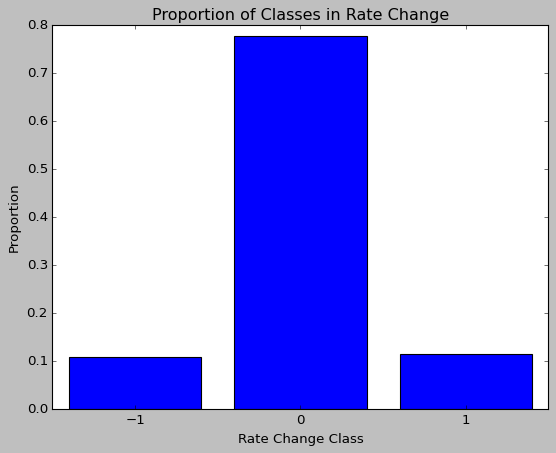

In [43]:
plt.style.use('classic')
# plot class proportions
rate_change_counts = ml_df['rate_change'].value_counts()
proportions = rate_change_counts / len(ml_df)

plt.figure(figsize=(8, 6))
plt.bar(proportions.index, proportions.values)
plt.xlabel("Rate Change Class")
plt.ylabel("Proportion")
plt.title("Proportion of Classes in Rate Change")
plt.xticks(proportions.index)
plt.show()

In [44]:
ml_df['Date'] = pd.to_datetime(ml_df['Date'])

In [ ]:
# date features
ml_df['year'] = ml_df['Date'].dt.year
ml_df['month'] = ml_df['Date'].dt.month
ml_df['quarter'] = ml_df['Date'].dt.quarter

In [46]:
def add_lag_and_pct_change_features(df, features, lags=[1]):
    """
    Add lag and percent change features for selected variables.

    Args:
        df (pd.DataFrame): Original time-indexed dataframe (e.g., with 'Date' as index).
        features (list): List of column names to create lag/pct change features for.
        lags (list): List of lag steps (e.g., [1, 2, 3]).

    Returns:
        pd.DataFrame: DataFrame with additional lag and percent change features.
    """
    ml_df = df.copy()

    for var in features:
        for lag in lags:
            # Lag feature
            df[f'{var}_lag{lag}'] = df[var].shift(lag)

            # Percent change feature (approximate return)
            df[f'{var}_pctchg{lag}'] = df[var].pct_change(periods=lag)

    return df

In [50]:
features = ['wage', 'rmpi', 'cpi', 'house_st', 'unemp', 'empl', 'lab_part', 'gdp', 'mf_ipi', 'us_fx', 'cn_fx', 'eu_fx', 'jp_fx', 'tsx_cl']

ml_df = add_lag_and_pct_change_features(ml_df, features, lags=[1, 3, 6, 9, 12])


/tmp/ipython-input-46-2104250066.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{var}_pctchg{lag}'] = df[var].pct_change(periods=lag)


,index,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,...,tsx_cl_lag1,tsx_cl_pctchg1,tsx_cl_lag3,tsx_cl_pctchg3,tsx_cl_lag6,tsx_cl_pctchg6,tsx_cl_lag9,tsx_cl_pctchg9,tsx_cl_lag12,tsx_cl_pctchg12
0,0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,...,9321.87,-0.133358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2001-03-01,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,...,8078.72,-0.058267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2001-04-01,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,...,7608.00,0.044510,9321.87,-0.147528,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2001-05-01,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,...,7946.63,0.027086,8078.72,0.010292,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Columns: 160 entries, index to tsx_cl_pctchg12
dtypes: datetime64[ns](1), float64(156), int64(3)
memory usage: 360.1 KB


CPI is a common indication of inflation, and interest rate changes are used as a counter-inflationary tool. I added in some extra features involving cpi.

In [52]:

# cpi rolling window - mean
ml_df['cpi_rolling_mean3'] = ml_df['cpi'].rolling(window = 3).mean()
ml_df['cpi_rolling_mean6'] = ml_df['cpi'].rolling(window = 6).mean()
ml_df['cpi_rolling_mean9'] = ml_df['cpi'].rolling(window = 9).mean()

/tmp/ipython-input-52-3343648516.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_rolling_mean3'] = ml_df['cpi'].rolling(window = 3).mean()
/tmp/ipython-input-52-3343648516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_rolling_mean6'] = ml_df['cpi'].rolling(window = 6).mean()
/tmp/ipython-input-52-3343648516.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [53]:

# cpi exp. moving avg - ema
ml_df['cpi_ema3'] = ml_df['cpi'].ewm(span = 3).mean()
ml_df['cpi_ema6'] = ml_df['cpi'].ewm(span = 6).mean()
ml_df['cpi_ema9'] = ml_df['cpi'].ewm(span = 9).mean()

/tmp/ipython-input-53-3604097986.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_ema3'] = ml_df['cpi'].ewm(span = 3).mean()
/tmp/ipython-input-53-3604097986.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_ema6'] = ml_df['cpi'].ewm(span = 6).mean()
/tmp/ipython-input-53-3604097986.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [54]:
# cpi volatility
ml_df['cpi_rolling_std3'] = ml_df['cpi'].rolling(window = 3).std()
ml_df['cpi_rolling_std6'] = ml_df['cpi'].rolling(window = 6).std()

/tmp/ipython-input-54-2908345007.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_rolling_std3'] = ml_df['cpi'].rolling(window = 3).std()
/tmp/ipython-input-54-2908345007.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_rolling_std6'] = ml_df['cpi'].rolling(window = 6).std()


In [55]:
ml_df['cpi_diff_rolling_mean3'] = ml_df['cpi'] - ml_df['cpi_rolling_mean3']
ml_df['cpi_diff_rolling_mean6'] = ml_df['cpi'] - ml_df['cpi_rolling_mean6']

/tmp/ipython-input-55-1394187235.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_diff_rolling_mean3'] = ml_df['cpi'] - ml_df['cpi_rolling_mean3']
/tmp/ipython-input-55-1394187235.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['cpi_diff_rolling_mean6'] = ml_df['cpi'] - ml_df['cpi_rolling_mean6']


In [57]:
# inflation deviation
ml_df['inflation_dev'] = ml_df['cpi_pctchg12'] - 2
ml_df['inflation_dev_lag3'] = ml_df['inflation_dev'].shift(3)
ml_df['inflation_dev_lag6'] = ml_df['inflation_dev'].shift(6)
ml_df['inflation_dev_lag9'] = ml_df['inflation_dev'].shift(9)

/tmp/ipython-input-57-2283276736.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['inflation_dev'] = ml_df['cpi_pctchg12'] - 2
/tmp/ipython-input-57-2283276736.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['inflation_dev_lag3'] = ml_df['inflation_dev'].shift(3)
/tmp/ipython-input-57-2283276736.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

In [58]:

# inflation trend - stabilizing or worsening?
ml_df['inflation_trend'] = ml_df['inflation_dev'].diff()
ml_df['inflation_trend_lag3'] = ml_df['inflation_trend'].shift(3)
ml_df['inflation_trend_lag6'] = ml_df['inflation_trend'].shift(6)
ml_df['inflation_trend_lag9'] = ml_df['inflation_trend'].shift(9)

/tmp/ipython-input-58-1767663113.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['inflation_trend'] = ml_df['inflation_dev'].diff()
/tmp/ipython-input-58-1767663113.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ml_df['inflation_trend_lag3'] = ml_df['inflation_trend'].shift(3)
/tmp/ipython-input-58-1767663113.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [59]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Columns: 178 entries, index to inflation_trend_lag9
dtypes: datetime64[ns](1), float64(174), int64(3)
memory usage: 400.6 KB


Now that lag features have been added, there will be some NA values in the first year of the data. These rows will need to be cut

In [62]:
ml_df[ml_df.isna().any(axis=1)]

,index,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,...,cpi_diff_rolling_mean3,cpi_diff_rolling_mean6,inflation_dev,inflation_dev_lag3,inflation_dev_lag6,inflation_dev_lag9,inflation_trend,inflation_trend_lag3,inflation_trend_lag6,inflation_trend_lag9
0,0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2001-03-01,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,...,0.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2001-04-01,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,...,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2001-05-01,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,...,0.766667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2001-06-01,656.81,63.9,98.7,155.286,7.2,61.1,65.9,1438295.0,...,0.333333,1.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2001-07-01,656.43,62.7,98.4,128.469,7.1,61.1,65.8,1436172.0,...,-0.166667,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2001-08-01,659.47,62.7,98.4,148.331,7.2,61.1,65.8,1440974.0,...,-0.100000,0.233333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2001-09-01,659.90,60.8,98.6,139.504,7.2,61.1,65.8,1433233.0,...,0.133333,0.183333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2001-10-01,660.91,57.7,98.1,148.167,7.3,61.1,65.9,1439780.0,...,-0.266667,-0.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
